# Load libraries

In [16]:
import matplotlib.pyplot as plt
import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session
from keras.backend import set_session
import keras
import sys, time, os, warnings 
import numpy as np
import pandas as pd 
from collections import Counter 
warnings.filterwarnings("ignore")

In [17]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Activation
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Embedding, TimeDistributed, RepeatVector, LSTM # ,Merge
from keras.preprocessing import sequence
import cv2, json, numpy as np

In [18]:
import numpy as np
import pandas as pd
import PIL
from matplotlib import pyplot as plt
%matplotlib inline

from keras import Sequential, Model
from keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, RepeatVector, Concatenate, Activation
from keras.activations import softmax
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam

from collections import Counter 

# Data preprocessing

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
## unzip the zip file
# import zipfile
# path_to_zip_file = "/content/drive/MyDrive/Colab Notebooks/5243/ads-spring-2022-prj5-group-[]/data/data.zip"
# directory_to_extract_to = "/content/drive/MyDrive/Colab Notebooks/5243/ads-spring-2022-prj5-group-[]/data"
# with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#     zip_ref.extractall(directory_to_extract_to)

In [21]:
## The location of the Flickr8K_ images
# fp = "/content/drive/MyDrive/ads-spring-2022-prj5-group-[]/"  #change to your path
fp = "/content/drive/MyDrive/Colab Notebooks/5243/ads-spring-2022-prj5-group-[]/"  #change to your path

dir_Flickr_jpg = fp + "data/Images/"
## The location of the caption file
dir_Flickr_text = fp + "data/captions.txt"

jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in Flicker8k: {}".format(len(jpgs)))

The number of jpg flies in Flicker8k: 8091


In [22]:
with open(dir_Flickr_text, 'r') as fp:
    num_lines = len(fp.readlines())
    print('Total lines:', num_lines) # 40456
# total number of lines excepting for the first meaningless line: 40455
# number of unique pictures: 8091
# number of captions for each image: 5

Total lines: 40456


In [23]:
#Finding the captions for each image.
file = open(dir_Flickr_text,'r', encoding='utf8')
text = file.read()
file.close()

datatxt = []

i = 0
for line in text.split('\n')[1:num_lines]:
    s = line.split(',',1) # will be matched 1 times.
    datatxt.append([s[0]] +[f"{i%5}"] +[s[1].lower()])
    i = i+1


df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])


uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df_txt.filename.values).values())
print(df_txt)

The number of unique file names : 8091
The distribution of the number of captions for each image:
                        filename index  \
0      1000268201_693b08cb0e.jpg     0   
1      1000268201_693b08cb0e.jpg     1   
2      1000268201_693b08cb0e.jpg     2   
3      1000268201_693b08cb0e.jpg     3   
4      1000268201_693b08cb0e.jpg     4   
...                          ...   ...   
40450   997722733_0cb5439472.jpg     0   
40451   997722733_0cb5439472.jpg     1   
40452   997722733_0cb5439472.jpg     2   
40453   997722733_0cb5439472.jpg     3   
40454   997722733_0cb5439472.jpg     4   

                                                 caption  
0      a child in a pink dress is climbing up a set o...  
1                  a girl going into a wooden building .  
2       a little girl climbing into a wooden playhouse .  
3      a little girl climbing the stairs to her playh...  
4      a little girl in a pink dress going into a woo...  
...                                        

Cleaning captions for further analysis

In [24]:
# Defining a function to calculate the top 3 words in all the captions available for the images
def df_word(df_txt):
    vocabulary = []
    for txt in df_txt.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":list(ct.keys()),"count":list(ct.values())})
    dfword = dfword.sort_values("count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(df_txt)
dfword.head(3)

Vocabulary Size: 9180


,word,count
0,a,61752
1,.,34212
2,in,18965


Cleaning the captions for further processing: clean punctuations, singular words and numerical values

In [25]:
import string
text_original = "I ate 1000 apples and a banana. I have python v2.7. It's 2:30 pm. Could you buy me iphone7?"

print(text_original)
print("\nRemove punctuations..")
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
    return(text_no_punctuation)
text_no_punctuation = remove_punctuation(text_original)
print(text_no_punctuation)


print("\nRemove a single character word..")
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)
text_len_more_than1 = remove_single_character(text_no_punctuation)
print(text_len_more_than1)

print("\nRemove words with numeric values..")
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)
text_no_numeric = remove_numeric(text_len_more_than1,printTF=True)
print(text_no_numeric)

I ate 1000 apples and a banana. I have python v2.7. It's 2:30 pm. Could you buy me iphone7?

Remove punctuations..
I ate 1000 apples and a banana I have python v27 Its 230 pm Could you buy me iphone7

Remove a single character word..
 ate 1000 apples and banana have python v27 Its 230 pm Could you buy me iphone7

Remove words with numeric values..
    ate        : True
    1000       : False
    apples     : True
    and        : True
    banana     : True
    have       : True
    python     : True
    v27        : False
    Its        : True
    230        : False
    pm         : True
    Could      : True
    you        : True
    buy        : True
    me         : True
    iphone7    : False
 ate apples and banana have python Its pm Could you buy me


In [26]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)


for i, caption in enumerate(df_txt.caption.values):
    newcaption = text_clean(caption)
    df_txt["caption"].iloc[i] = newcaption

Adding start and end sequence tokens for each captions

In [27]:
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)
df_txt0 = copy(df_txt)
df_txt0["caption"] = add_start_end_seq_token(df_txt["caption"])
df_txt0.head(5)
del df_txt

In [ ]:
df_txt0[:10]

,filename,index,caption
0,1000268201_693b08cb0e.jpg,0,startseq child in pink dress is climbing up s...
1,1000268201_693b08cb0e.jpg,1,startseq girl going into wooden building endseq
2,1000268201_693b08cb0e.jpg,2,startseq little girl climbing into wooden pla...
3,1000268201_693b08cb0e.jpg,3,startseq little girl climbing the stairs to h...
4,1000268201_693b08cb0e.jpg,4,startseq little girl in pink dress going into...
5,1001773457_577c3a7d70.jpg,0,startseq black dog and spotted dog are fighti...
6,1001773457_577c3a7d70.jpg,1,startseq black dog and tricolored dog playing...
7,1001773457_577c3a7d70.jpg,2,startseq black dog and white dog with brown s...
8,1001773457_577c3a7d70.jpg,3,startseq two dogs of different breeds looking...
9,1001773457_577c3a7d70.jpg,4,startseq two dogs on pavement moving toward e...


# Extract features using inception_resnet_v2

In [29]:
import tensorflow.keras as K

fp = "/content/drive/MyDrive/Colab Notebooks/5243/ads-spring-2022-prj5-group-[]/"  #change to your path
model_incepv2 = K.applications.inception_resnet_v2.InceptionResNetV2(include_top=True,weights=None)
## load the locally saved weights 
model_incepv2.load_weights(fp + "data/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5")
model_incepv2.summary()


Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_203 (Batch  (None, 149, 149, 32  96         ['conv2d_203[0][0]']             
 Normalization)                 )                                               

In [30]:
from keras import models
model_incepv2.layers.pop()
model_incepv2 = models.Model(inputs=model_incepv2.inputs, outputs=model_incepv2.layers[-2].output)
## show the deep learning model
model_incepv2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_203 (Batch  (None, 149, 149, 32  96         ['conv2d_203[0][0]']             
 Normalization)                 )                                                             

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.inception_resnet_v2 import preprocess_input
from collections import OrderedDict

import numpy as np

images = OrderedDict()
npix = 299 
target_size = (npix,npix,3)
data = np.zeros((len(jpgs),npix,npix,3))
for i,name in enumerate(jpgs):
    # load an image from file
    filename = dir_Flickr_jpg + '/' + name
    image = load_img(filename, target_size=target_size)
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    nimage = preprocess_input(image)
    
    y_pred = model_incepv2.predict(nimage.reshape( (1,) + nimage.shape[:3]))
    images[name] = y_pred.flatten()

In [ ]:
# import pickle
# with open('output/image_feature', 'wb') as fp:
#     pickle.dump(images, fp)

In [ ]:
# read the saved 'images' variable back

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
import pickle
# fp = "/content/drive/MyDrive/ads-spring-2022-prj5-group-[]/"  #change to your path
fp = "/content/drive/MyDrive/Colab Notebooks/5243/ads-spring-2022-prj5-group-[]/"  #change to your path
with open(fp + 'output/image_feature', 'rb') as f:
    images = pickle.load(f)

In [ ]:
# images

# Merging the images and the captions for training

In [33]:
dimages, keepindex = [],[]
# Creating a datframe where only first caption is taken for processing
df_txt0 = df_txt0.loc[df_txt0["index"].values == "0",: ]
for i, fnm in enumerate(df_txt0.filename):
    if fnm in images.keys():
        dimages.append(images[fnm])
        keepindex.append(i)

#fnames are the names of the image files        
fnames = df_txt0["filename"].iloc[keepindex].values
#dcaptions are the captions of the images 
dcaptions = df_txt0["caption"].iloc[keepindex].values
#dimages are the actual features of the images
dimages = np.array(dimages)

# Tokenizing the captions for further processing

In [34]:
from keras.preprocessing.text import Tokenizer
## the maximum number of words in dictionary
nb_words = 6000
tokenizer = Tokenizer(nb_words=nb_words)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)
print(dtexts[:5])

vocabulary size : 4476
[[1, 38, 3, 66, 144, 7, 124, 52, 406, 9, 367, 3, 24, 2351, 522, 2], [1, 12, 8, 5, 752, 8, 17, 368, 2], [1, 48, 15, 170, 3, 584, 101, 3, 41, 9, 551, 1198, 11, 55, 213, 3, 1076, 2], [1, 10, 621, 6, 150, 27, 23, 8, 101, 46, 112, 2], [1, 10, 3, 24, 82, 96, 1199, 19, 162, 2]]


# Splitting the training and test data

In [35]:
prop_test, prop_val = 0.2, 0.2 

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

In [36]:
maxlen = np.max([len(text) for text in dtexts])
print(maxlen)

30


In [37]:
from keras.preprocessing.sequence import pad_sequences

def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages)) # using assert to make sure that length of images and captions are always similar
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):
        # zip() is used to create a tuple of iteratable items
        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()# using pad sequence to make the length of all captions equal
            out_text = to_categorical(out_text,num_classes = vocab_size) # using to_categorical to 

            
            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)

# captions/images = 4855
 (49631, 30) (49631, 1536) (49631, 4476)
# captions/images = 1618
 (16353, 30) (16353, 1536) (16353, 4476)


# Training the LSTM model

In [ ]:
from keras import layers
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras import models
print(vocab_size)
## image feature

dim_embedding = 64

input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(256,activation='relu',name="ImageFeature")(input_image)
## sequence model
input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256,name="CaptionFeature",return_sequences=True)(ftxt)
#,return_sequences=True
#,activation='relu'
se2 = Dropout(0.04)(ftxt)
ftxt = layers.LSTM(256,name="CaptionFeature2")(se2)
## combined model for decoder
decoder = layers.add([ftxt,fimage])
decoder = layers.Dense(256,activation='relu')(decoder)
output = layers.Dense(vocab_size,activation='softmax')(decoder)
model = models.Model(inputs=[input_image, input_txt],outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

4476
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 64)       286464      ['input_2[0][0]']                
                                                                                                  
 CaptionFeature (LSTM)          (None, 30, 256)      328704      ['embedding[0][0]']              
                                                                                                  
 dropout (Dropout)              (None, 30, 256)      0           ['CaptionFeature[0][0]']         
                                                                                         

In [ ]:
# set parameters for autosaving the model with the best validation accuracy
fp = "/content/drive/MyDrive/Colab Notebooks/5243/ads-spring-2022-prj5-group-[]/"
filepath_model_2 = fp + "output/saved_model/InceptionResNetV2_LSTM"
# reduce learning rate when val_accuracy has stopped improving
import tensorflow.keras as K

lr_reduce = K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                          factor=0.6,
                                          patience=2,
                                          verbose=1,
                                          mode='max',
                                          min_lr=1e-7)
# stop training when val_accuracy has stopped improving
early_stop = K.callbacks.EarlyStopping(monitor='val_accuracy',
                                       patience=3,
                                       verbose=1,
                                       mode='max')
# callback to save the Keras model and (best) weights obtained on an epoch basis. here, the trained (compiled) model is saved in the current working directory as ''
checkpoint = K.callbacks.ModelCheckpoint(filepath=filepath_model_2, # remember to change the path
                                         monitor='val_accuracy',
                                         verbose=1,
                                         save_weights_only=False,
                                         save_best_only=True,
                                         mode='max',
                                         save_freq='epoch')

In [ ]:
# fit model
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
# start = time.time()
hist = model.fit([Ximage_train, Xtext_train], ytext_train, 
                  epochs = 10, verbose=2, 
                  batch_size=32,
                  validation_data=([Ximage_val, Xtext_val], ytext_val),
                 # callbacks=[tensorboard]
                 callbacks=[lr_reduce, early_stop, checkpoint])
# end = time.time()

Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.23727, saving model to /content/drive/MyDrive/Colab Notebooks/5243/ads-spring-2022-prj5-group-[]/output/saved_model/InceptionResNetV2_LSTM


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/5243/ads-spring-2022-prj5-group-[]/output/saved_model/InceptionResNetV2_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/5243/ads-spring-2022-prj5-group-[]/output/saved_model/InceptionResNetV2_LSTM/assets


1551/1551 - 576s - loss: 5.2210 - accuracy: 0.1755 - val_loss: 4.6357 - val_accuracy: 0.2373 - lr: 0.0010 - 576s/epoch - 371ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.23727 to 0.27224, saving model to /content/drive/MyDrive/Colab Notebooks/5243/ads-spring-2022-prj5-group-[]/output/saved_model/InceptionResNetV2_LSTM


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/5243/ads-spring-2022-prj5-group-[]/output/saved_model/InceptionResNetV2_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/5243/ads-spring-2022-prj5-group-[]/output/saved_model/InceptionResNetV2_LSTM/assets


1551/1551 - 549s - loss: 4.2762 - accuracy: 0.2518 - val_loss: 4.3843 - val_accuracy: 0.2722 - lr: 0.0010 - 549s/epoch - 354ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.27224 to 0.28435, saving model to /content/drive/MyDrive/Colab Notebooks/5243/ads-spring-2022-prj5-group-[]/output/saved_model/InceptionResNetV2_LSTM


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/5243/ads-spring-2022-prj5-group-[]/output/saved_model/InceptionResNetV2_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/5243/ads-spring-2022-prj5-group-[]/output/saved_model/InceptionResNetV2_LSTM/assets


1551/1551 - 560s - loss: 3.8363 - accuracy: 0.2786 - val_loss: 4.2824 - val_accuracy: 0.2844 - lr: 0.0010 - 560s/epoch - 361ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.28435 to 0.29181, saving model to /content/drive/MyDrive/Colab Notebooks/5243/ads-spring-2022-prj5-group-[]/output/saved_model/InceptionResNetV2_LSTM


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/5243/ads-spring-2022-prj5-group-[]/output/saved_model/InceptionResNetV2_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/5243/ads-spring-2022-prj5-group-[]/output/saved_model/InceptionResNetV2_LSTM/assets


1551/1551 - 546s - loss: 3.5404 - accuracy: 0.2968 - val_loss: 4.3106 - val_accuracy: 0.2918 - lr: 0.0010 - 546s/epoch - 352ms/step
Epoch 5/10

Epoch 5: val_accuracy improved from 0.29181 to 0.29701, saving model to /content/drive/MyDrive/Colab Notebooks/5243/ads-spring-2022-prj5-group-[]/output/saved_model/InceptionResNetV2_LSTM


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/5243/ads-spring-2022-prj5-group-[]/output/saved_model/InceptionResNetV2_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/5243/ads-spring-2022-prj5-group-[]/output/saved_model/InceptionResNetV2_LSTM/assets


1551/1551 - 553s - loss: 3.3039 - accuracy: 0.3132 - val_loss: 4.4668 - val_accuracy: 0.2970 - lr: 0.0010 - 553s/epoch - 357ms/step
Epoch 6/10

Epoch 6: val_accuracy improved from 0.29701 to 0.29952, saving model to /content/drive/MyDrive/Colab Notebooks/5243/ads-spring-2022-prj5-group-[]/output/saved_model/InceptionResNetV2_LSTM


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/5243/ads-spring-2022-prj5-group-[]/output/saved_model/InceptionResNetV2_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/5243/ads-spring-2022-prj5-group-[]/output/saved_model/InceptionResNetV2_LSTM/assets


1551/1551 - 553s - loss: 3.0995 - accuracy: 0.3255 - val_loss: 4.5880 - val_accuracy: 0.2995 - lr: 0.0010 - 553s/epoch - 357ms/step
Epoch 7/10

Epoch 7: val_accuracy did not improve from 0.29952
1551/1551 - 524s - loss: 2.9058 - accuracy: 0.3410 - val_loss: 4.7782 - val_accuracy: 0.2995 - lr: 0.0010 - 524s/epoch - 338ms/step
Epoch 8/10

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 8: val_accuracy did not improve from 0.29952
1551/1551 - 535s - loss: 2.7192 - accuracy: 0.3584 - val_loss: 5.0042 - val_accuracy: 0.2976 - lr: 0.0010 - 535s/epoch - 345ms/step
Epoch 9/10

Epoch 9: val_accuracy did not improve from 0.29952
1551/1551 - 521s - loss: 2.4256 - accuracy: 0.3967 - val_loss: 5.3005 - val_accuracy: 0.2995 - lr: 6.0000e-04 - 521s/epoch - 336ms/step
Epoch 9: early stopping


In [ ]:
# # fit model
# from time import time
# from keras.callbacks import TensorBoard
# tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
# # start = time.time()
# hist = model.fit([Ximage_train, Xtext_train], ytext_train, 
#                   epochs = 10, verbose=2, 
#                   batch_size=32,
#                   validation_data=([Ximage_val, Xtext_val], ytext_val),
#                  callbacks=[tensorboard])
# # end = time.time()

In [ ]:
# # Save the fit history
# import pickle
# with open(fp + 'output/evaluation_model/InceptionResNetV2_LSTM_hisotry', 'wb') as fp:
#     pickle.dump(hist, fp)

In [ ]:
# # Load the history fit back from the pickle file.
# import pickle
# fp = "/content/drive/MyDrive/Colab Notebooks/5243/ads-spring-2022-prj5-group-[]/"  #change to your path
# hist = pickle.load(open(fp + "output/evaluation_model/InceptionResNetV2_LSTM_hisotry", "rb"))

In [40]:
# load the model
import tensorflow.keras as K
fp = "/content/drive/MyDrive/Colab Notebooks/5243/ads-spring-2022-prj5-group-[]/"  #change to your path
filepath_model_2 = fp + 'output/saved_model/InceptionResNetV2_LSTM'
model = K.models.load_model(filepath=filepath_model_2)

In [ ]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

#Generating captions on a small set of images


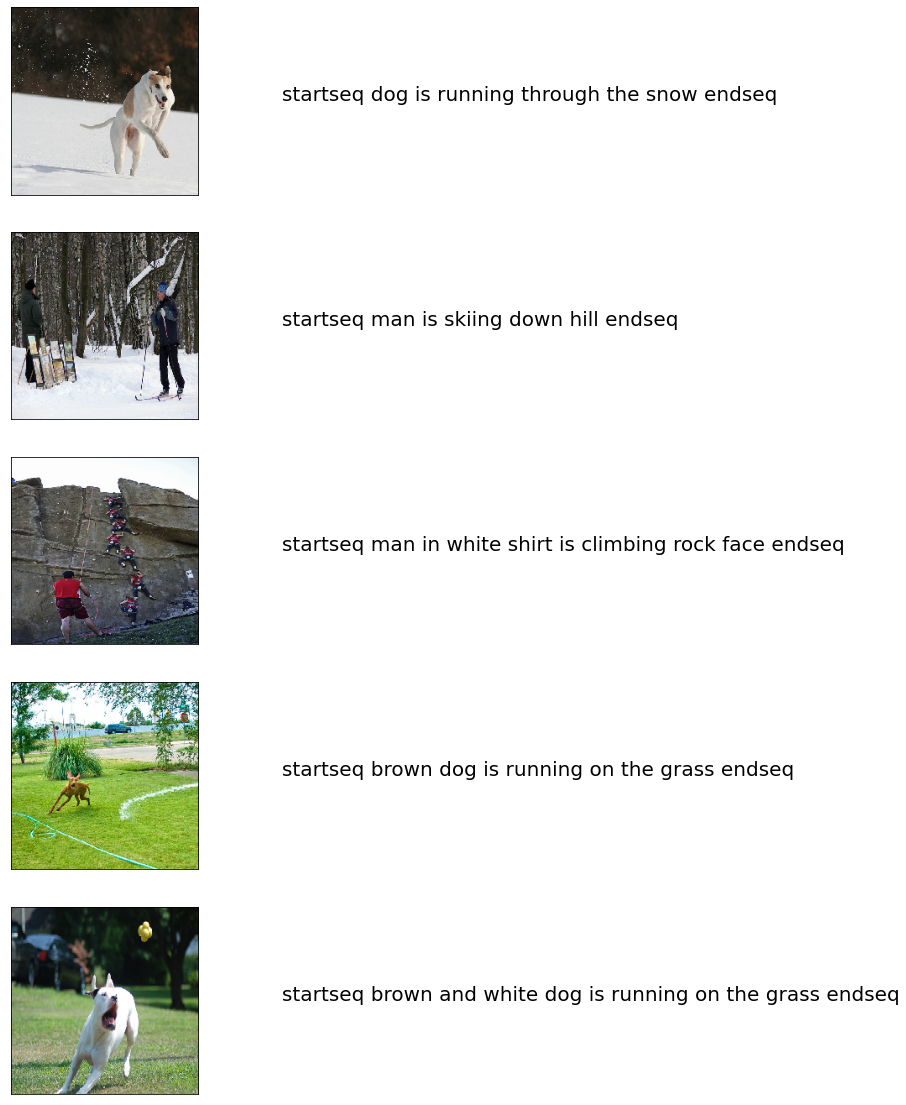

In [41]:
from keras.preprocessing.image import load_img, img_to_array
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
def predict_caption(image):
    '''
    image.shape = (1,4462)
    '''

    in_text = 'startseq'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)



npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_test[10:15],di_test[10:15]):
    ## images 
    filename = dir_Flickr_jpg + '/' + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()

#Evaluating the captions for test data by finding BLEU score 

In [42]:
from nltk.translate.bleu_score import sentence_bleu

index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])


nkeep = 5
pred_good, pred_bad, bleus = [], [], [] 
count = 0 
for jpgfnm, image_feature, tokenized_text in zip(fnm_test,di_test,dt_test):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(fnm_test))))
    
    caption_true = [ index_word[i] for i in tokenized_text ]     
    caption_true = caption_true[1:-1] ## remove startreg, and endreg
    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1]## remove startreg, and endreg
    
    bleu = sentence_bleu([caption_true],caption)
    bleus.append(bleu)
    if bleu > 0.7 and len(pred_good) < nkeep:
        pred_good.append((bleu,jpgfnm,caption_true,caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu,jpgfnm,caption_true,caption))

  12.36% is done..
  24.72% is done..
  37.08% is done..
  49.44% is done..
  61.80% is done..
  74.17% is done..
  86.53% is done..
  98.89% is done..


In [43]:
print("Mean BLEU {:4.3f}".format(np.mean(bleus)))

Mean BLEU 0.401


#5 good and 5 bad captions examples from the model

Bad Caption


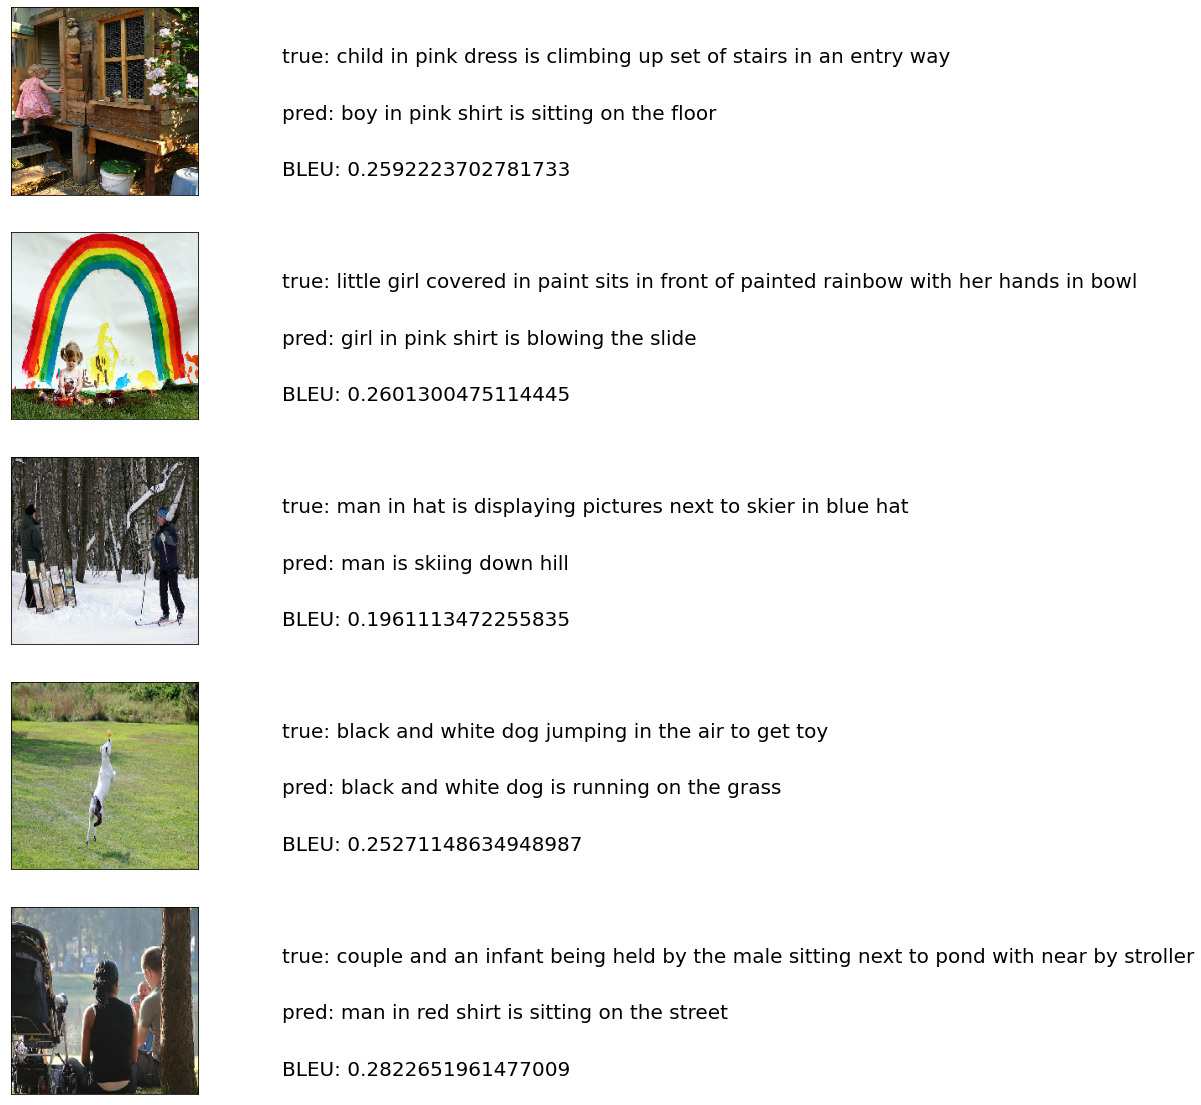

Good Caption


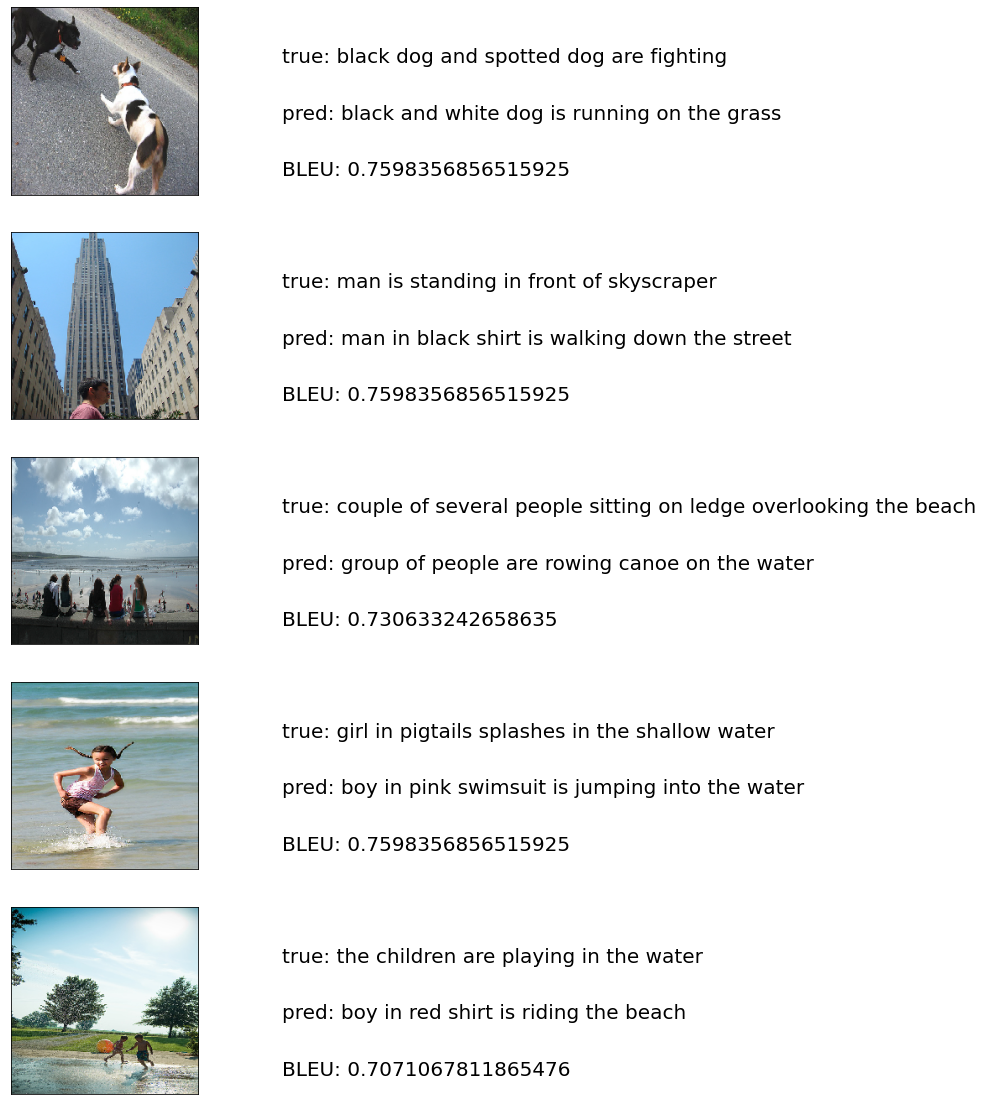

In [44]:
def plot_images(pred_bad):
    def create_str(caption_true):
        strue = ""
        for s in caption_true:
            strue += " " + s
        return(strue)
    npix = 224
    target_size = (npix,npix,3)    
    count = 1
    fig = plt.figure(figsize=(10,20))
    npic = len(pred_bad)
    for pb in pred_bad:
        bleu,jpgfnm,caption_true,caption = pb
        ## images 
        filename = dir_Flickr_jpg + '/' + jpgfnm
        image_load = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        caption_true = create_str(caption_true)
        caption = create_str(caption)
        
        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.7,"true:" + caption_true,fontsize=20)
        ax.text(0,0.4,"pred:" + caption,fontsize=20)
        ax.text(0,0.1,"BLEU: {}".format(bleu),fontsize=20)
        count += 1
    plt.show()

print("Bad Caption")
plot_images(pred_bad)
print("Good Caption")
plot_images(pred_good)

Reference:

LSTM: https://github.com/MITESHPUTHRANNEU/Image-Caption-Generator

Multiple layers of RNN/LSTM/GRU: https://github.com/AndreeaMusat/Deep-Learning-Image-Captioning

CNN and LSTM in PyTorch: https://www.analyticsvidhya.com/blog/2018/04/solving-an-image-captioning-task-using-deep-learning/

RNN: https://github.com/jonkuo/Deep-Learning-Image-Captioning

https://arxiv.org/abs/1409.4842